In [1]:
# Loading required libraries and initializing
from langdetect import DetectorFactory
from pandas import Series, DataFrame
from string import punctuation
from nltk.tokenize import word_tokenize

In [2]:
# Loading custom defined functions
from tokenization import tokenize_sentence_nltk, tokenize_treetagger
from util import read_file, flatten_list_of_list, read_folder#, clean_sentences
from util import pick_first_language, is_english_wp_p, spell_correct_tokens
from util import detect_language, postprocess_sentences, get_redundaunt_info
from util import filter_data, filter_senders, filter_recipients, search_patterns
from pos_tagging import run_treetagger_pos_tag_text
from modeling import apply_bigram_trigram_model, run_aff_prop_with_distances, run_kmeans
from nltk.stem import WordNetLemmatizer
from modeling import run_word2vec_model, run_lda_topic_model, build_logistic_regression
from visualizing import visualize_word2vec_model
from util import get_semantic_similarity, get_character_similarity
from lemmatization import lemmatize_treetagger
from util import run_treetagger, join_tokens, parse_date, is_spelled_correctly, process_from_for_date
from json import load
from numpy import isnan
from util import get_contents_meta_data
from re import findall

C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
DetectorFactory.seed = 0

in_file = load(open("in_file.cfg", 'r'))
patterns_file = in_file["patterns_file"]
file_folder = in_file["file_folder"]
label = in_file["label"]
column = in_file["column"]
in_type = in_file["in_type"]
in_file = in_file["in_file"]
if file_folder == "file":
    strings = read_file(in_file, in_type = in_type)
    if in_type == "text":
        strings = tokenize_sentence_nltk(strings)
        strings = DataFrame(strings)[0]
    elif in_type == "html_chat":
        timestamp = strings[2]
        meta_data = strings[1]
        strings = strings[0]
        strings[label] = meta_data["Comment"]
        labels = strings[label]
        strings = strings[col]
    else:
        if label in strings.columns:
            labels = strings[label]
        strings = strings[col]
else:
    print(in_type)
    strings = read_folder(folder = in_file, in_type = in_type)

patterns = Series([".*" + x + ".*" for x in open(patterns_file, 'r').readlines()])

# For html_chat:
# strings -> DataFrame; meta_data -> Series; timestamp -> Series

# For csv, html_email, enron_email:
# strings -> DataFrame

# For folder:
# Sames as file

# html_email and enron_email will have columns 'conversation' (string) and 'meta_data' (dictionary)

# html_chat will have columns "itemId", "messageType", "messageDirection", "case", "captureDate", "policyAction", "statusMarkDate", "status", "status_reviewer", "commentDate", "comment", "comment_reviewer", "participants", "timestamp", "language", "sender", "recipients", "subject", "conversation", "num_of_conversation_turns" and "messages"

enron_email
Enron/maildir/allen-p/inbox/1
Enron/maildir/allen-p/inbox/10
Enron/maildir/allen-p/inbox/11
Enron/maildir/allen-p/inbox/12
Enron/maildir/allen-p/inbox/13
Enron/maildir/allen-p/inbox/14
Enron/maildir/allen-p/inbox/15
Enron/maildir/allen-p/inbox/16
Enron/maildir/allen-p/inbox/17
Enron/maildir/allen-p/inbox/18
Enron/maildir/allen-p/inbox/19
Enron/maildir/allen-p/inbox/2
Enron/maildir/allen-p/inbox/20
Enron/maildir/allen-p/inbox/21
Enron/maildir/allen-p/inbox/22
Enron/maildir/allen-p/inbox/23
Enron/maildir/allen-p/inbox/24
Enron/maildir/allen-p/inbox/25
Enron/maildir/allen-p/inbox/26
Enron/maildir/allen-p/inbox/27
Enron/maildir/allen-p/inbox/28
Enron/maildir/allen-p/inbox/29
Enron/maildir/allen-p/inbox/3
Enron/maildir/allen-p/inbox/30
Enron/maildir/allen-p/inbox/31
Enron/maildir/allen-p/inbox/32
Enron/maildir/allen-p/inbox/33
Enron/maildir/allen-p/inbox/34
Enron/maildir/allen-p/inbox/35
Enron/maildir/allen-p/inbox/36
Enron/maildir/allen-p/inbox/37
Enron/maildir/allen-p/inbox/38

In [4]:
strings.shape

(88, 2)

In [5]:
def na_date_filling_possible(x):
    try:
        if type(x) == float:
            return " on " in x['from'] and isnan(x['date'])
        else:
            return " on " in x['from'] and x['date'] is None
    except:
        return False

if in_type == "html_email" or in_type == "enron_email":
    conv = strings["conversation"].apply(tokenize_sentence_nltk)
    strings = strings["meta_data"].apply(Series)
    strings["conversation"] = conv
    strings["sent"] = strings["sent"].apply(parse_date)
    strings["date"] = strings["date"].apply(parse_date) # This is time consuming function, but it is robust
    if in_type == "enron_email":
        condition = strings['date'].apply(lambda x: x is None)
        strings["date"][condition] = strings["sent"][condition]

condition = strings["date"].apply(lambda x: x is None)
print(condition.sum())

# For html_email, enron_email ->
# 1) tokenize the strings to create list of sentences
# 2) convert meta data from dictionary to columns
# 3) parse "Sent" and "Date" columns from string to datetime.datetime (1900-01-01 00:00:00 is equivalent to NULL)

0


C:\Users\Naveen\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
def extract_from_date(strings):
    condition = strings[['from', 'date']].apply(lambda x: na_date_filling_possible(x), axis=1)
    if condition.sum() > 0:
        df = DataFrame(strings['from'][condition].apply(lambda x: process_from_for_date(x)).tolist())
        df.columns = ["from", "date"]
        strings['from'][condition] = df['from'].tolist()
        strings['date'][condition] = df['date'].tolist()
    return strings

strings = extract_from_date(strings)

In [7]:
def is_nan(x):
    try:
        return isnan(x)
    except:
        return False

strings['date'][strings['date'].apply(lambda x: is_nan(x))] = None
condition = strings['date'].apply(lambda x: x is None)

C:\Users\Naveen\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [8]:
strings.head()

,date,from,to,subject,mimeversion,contenttype,contenttransferencoding,xfrom,xto,xcc,xbcc,xfolder,xorigin,xfilename,sent,cc,conversation
0,2001-12-07 10:06:42,heather.dunton@enron.com,k..allen@enron.com,RE: West Position,1.0,text/plain; charset=us-ascii,7bit,"Dunton, Heather </O=ENRON/OU=NA/CN=RECIPIENTS/...","Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",,,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox",Allen-P,pallen (Non-Privileged).pst,NaT,NaN,[Please let me know if you still need Curve Sh...
1,NaT,NaN,"Dunton, Heather",RE: West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-07 05:14:00,NaN,"[Heather, ., Did you attach the file to this e..."
2,NaT,NaN,"Allen, Phillip K.; Belden, Tim",FW: West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-05 13:43:00,NaN,"[Attached is the Delta position for 1/16, 1/30..."
3,NaT,NaN,"Dunton, Heather",RE: West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-05 06:41:00,NaN,"[Heather, ., This is exactly what we need ., W..."
4,NaT,NaN,"Belden, Tim; Allen, Phillip K",West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-04 15:12:00,"Driscoll, Michael M","[Attached is the Delta position for 1/18, 1/31..."


In [9]:
if in_type == "html_chat":
    redundant = get_redundaunt_info(strings)
    total_redundant = redundant.sum()
    unnecessary1 = strings['sender'].apply(lambda x: len(findall("^gg.*", x.lower())) > 0)
    unnecessary2 = strings['participants'].apply(lambda x: sum([len(findall("^gg.*|\;gg.*", y)) for y in x]) > 0)
    unnecessary = unnecessary1 | unnecessary2
    total_unnecessary = unnecessary.sum()
    # Deduplication
    strings = filter_senders(strings)
    strings = filter_recipients(strings)
    strings = filter_data(strings)
    strings1 = strings.drop(['messages'], axis = 1).reset_index(drop = True)
    strings = strings['messages'].reset_index(drop = True)
    strings = strings.apply(lambda x: " ".join(x))

# For html_chat ->
# Remove unnecessary chat history: gg.* is the pattern for unwanted senders/participants
# Remove duplicate chats
# strings1 is a DataFrame with all columns except 'messages'
# strings is a Series (string) which is used for downstream NLP

In [10]:
strings.head()

,date,from,to,subject,mimeversion,contenttype,contenttransferencoding,xfrom,xto,xcc,xbcc,xfolder,xorigin,xfilename,sent,cc,conversation
0,2001-12-07 10:06:42,heather.dunton@enron.com,k..allen@enron.com,RE: West Position,1.0,text/plain; charset=us-ascii,7bit,"Dunton, Heather </O=ENRON/OU=NA/CN=RECIPIENTS/...","Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",,,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox",Allen-P,pallen (Non-Privileged).pst,NaT,NaN,[Please let me know if you still need Curve Sh...
1,NaT,NaN,"Dunton, Heather",RE: West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-07 05:14:00,NaN,"[Heather, ., Did you attach the file to this e..."
2,NaT,NaN,"Allen, Phillip K.; Belden, Tim",FW: West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-05 13:43:00,NaN,"[Attached is the Delta position for 1/16, 1/30..."
3,NaT,NaN,"Dunton, Heather",RE: West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-05 06:41:00,NaN,"[Heather, ., This is exactly what we need ., W..."
4,NaT,NaN,"Belden, Tim; Allen, Phillip K",West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-04 15:12:00,"Driscoll, Michael M","[Attached is the Delta position for 1/18, 1/31..."


In [11]:
patts = ["[Dd]ate:", "[Ss]ent:", "[Tt]o:", "[Ss]ubject:", "[Cc][Cc]:"]
patts = [patt + "[\t\ ]*" for patt in patts]
patts = "|".join(patts)
meta_data_start_pattern = ["[a-zA-Z\-_0-9]*@[a-zA-Z\-_0-9]*[\.a-z0-9]* on [0-9]{2}/[0-9]{2}/[0-9]{4} [0-9]{2}:[0-9]{2}:[0-9]{2} [AaPp][Mm]"]
meta_data_stop_pattern = ["^[\>\t\ ]*[sS]ubject:[\ \t]*"]
meta_data_start_pattern = "|".join(meta_data_start_pattern)
meta_data_stop_pattern = "|".join(meta_data_stop_pattern)

def nulls(x):
    if type(x) == float:
        return True
    else:
        return False

def postprocess_contents_meta_data(x, patts, meta_data_start_pattern, meta_data_stop_pattern, in_type = "html_email", meta_data = []):
    c_m = get_contents_meta_data(all_content = x['conversation'], all_fields_pattern = patts, metadata_start_pattern = meta_data_start_pattern, metadata_stop_pattern = meta_data_stop_pattern, in_type = in_type, meta_data = meta_data)
    content_meta = []
    c_m = list(c_m)
    dic = {'conversation': c_m[0][0]}
    for i in x.index:
        if i != 'conversation':
            dic[i] = x[i]
    content_meta.append(dic)
    if len(c_m[1]) > 0:    
        c_m[0] = c_m[0][1:]
        for i in range(len(c_m[0])):
            c_m[1][i]['content'] = c_m[0][i]
        content_meta = content_meta + c_m[1]
    
    return content_meta

In [12]:
def get_strings(strings, patts, meta_data_start_pattern, meta_data_stop_pattern, in_type = "html_email", meta_data = []):
    content_meta = []
    for i in range(strings.shape[0]):
        content_meta = content_meta + postprocess_contents_meta_data(strings.iloc[i], patts, meta_data_start_pattern, meta_data_stop_pattern, in_type, meta_data)

    strings = Series(content_meta)
    strings = strings.apply(Series)
    strings["conversation"][strings["conversation"].apply(nulls)] = ""
    strings["conversation"] = strings["conversation"].apply(tokenize_sentence_nltk)
    strings = extract_from_date(strings)
    return strings

strings = get_strings(strings, patts, meta_data_start_pattern, meta_data_stop_pattern, in_type = "html_email", meta_data = [])
strings.head()

C:\Users\Naveen\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,conversation,date,from,to,subject,mimeversion,contenttype,contenttransferencoding,xfrom,xto,xcc,xbcc,xfolder,xorigin,xfilename,sent,cc
0,[Please let me know if you still need Curve Sh...,2001-12-07 10:06:42,heather.dunton@enron.com,k..allen@enron.com,RE: West Position,1.0,text/plain; charset=us-ascii,7bit,"Dunton, Heather </O=ENRON/OU=NA/CN=RECIPIENTS/...","Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",,,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox",Allen-P,pallen (Non-Privileged).pst,NaT,NaN
1,"[Heather, ., Did you attach the file to this e...",NaT,NaN,"Dunton, Heather",RE: West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-07 05:14:00,NaN
2,"[Attached is the Delta position for 1/16, 1/30...",NaT,NaN,"Allen, Phillip K.; Belden, Tim",FW: West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-05 13:43:00,NaN
3,"[Heather, ., This is exactly what we need ., W...",NaT,NaN,"Dunton, Heather",RE: West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-05 06:41:00,NaN
4,"[Attached is the Delta position for 1/18, 1/31...",NaT,NaN,"Belden, Tim; Allen, Phillip K",West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-04 15:12:00,"Driscoll, Michael M"


In [13]:
meta_data_start_pattern = meta_data_stop_pattern = "^[\>\ ]{1,}[Dd]ate:"
strings = get_strings(strings, patts, meta_data_start_pattern, meta_data_stop_pattern, in_type = "html_email", meta_data = [])
strings.head()

C:\Users\Naveen\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,conversation,date,from,to,subject,mimeversion,contenttype,contenttransferencoding,xfrom,xto,xcc,xbcc,xfolder,xorigin,xfilename,sent,cc
0,[Please let me know if you still need Curve Sh...,2001-12-07 10:06:42,heather.dunton@enron.com,k..allen@enron.com,RE: West Position,1.0,text/plain; charset=us-ascii,7bit,"Dunton, Heather </O=ENRON/OU=NA/CN=RECIPIENTS/...","Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",,,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox",Allen-P,pallen (Non-Privileged).pst,NaT,NaN
1,"[Heather, ., Did you attach the file to this e...",NaT,NaN,"Dunton, Heather",RE: West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-07 05:14:00,NaN
2,"[Attached is the Delta position for 1/16, 1/30...",NaT,NaN,"Allen, Phillip K.; Belden, Tim",FW: West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-05 13:43:00,NaN
3,"[Heather, ., This is exactly what we need ., W...",NaT,NaN,"Dunton, Heather",RE: West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-05 06:41:00,NaN
4,"[Attached is the Delta position for 1/18, 1/31...",NaT,NaN,"Belden, Tim; Allen, Phillip K",West Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-12-04 15:12:00,"Driscoll, Michael M"


In [14]:
def get_dt(x):
    try:
        month = str(x.month)
        day = str(x.day)
        if day != 'nan':
            return str(x.year) + "/" + "0"*(2-len(month)) + month + "/" + "0"*(2-len(day)) + day
        else:
            return None
    except:
        return None

strings["dt"] = strings["date"].apply(lambda x: get_dt(x))

In [15]:
import pandas
others = strings[strings['date'].apply(lambda x: x is None or type(x) == pandas._libs.tslibs.nattype.NaTType)]
strings = strings[strings['date'].apply(lambda x: x is not None and type(x) != pandas._libs.tslibs.nattype.NaTType)]
strings.head()

,conversation,date,from,to,subject,mimeversion,contenttype,contenttransferencoding,xfrom,xto,xcc,xbcc,xfolder,xorigin,xfilename,sent,cc,dt
0,[Please let me know if you still need Curve Sh...,2001-12-07 10:06:42,heather.dunton@enron.com,k..allen@enron.com,RE: West Position,1.0,text/plain; charset=us-ascii,7bit,"Dunton, Heather </O=ENRON/OU=NA/CN=RECIPIENTS/...","Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",,,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox",Allen-P,pallen (Non-Privileged).pst,NaT,NaN,2001/12/07
5,[_____________________DAVID COURSEY___________...,2001-12-30 22:49:42,anchordesk_daily@anchordesk.zdlists.com,pallen@enron.com,ANCHORDESK: Hope ahead: What I learned from 20...,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,"AnchorDesk"" <AnchorDesk_Daily@anchordesk.zdlis...",pallen@ENRON.COM,,,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox",Allen-P,pallen (Non-Privileged).pst,NaT,NaN,2001/12/30
6,"[Dear phillip, ., This e-mail is automated not...",2001-12-30 23:42:30,subscriptions@intelligencepress.com,pallen@enron.com,"NGI Publications - Monday, December 31st 2001",1.0,text/plain; charset=us-ascii,7bit,subscriptions@intelligencepress.com@ENRON,pallen@enron.com,,,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox",Allen-P,pallen (Non-Privileged).pst,NaT,NaN,2001/12/30
7,"[[IMAGE] [IMAGE] [IMAGE] [IMAGE] $ 2,500 [...",2001-12-31 02:24:51,prizemachine@feedback.iwon.com,pallen@enron.com,"Click. Spin. Chances to Win up to $10,000",1.0,text/plain; charset=us-ascii,7bit,Prize Machine<PrizeMachine@feedback.iwon.com>@...,pallen@enron.com,,,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox",Allen-P,pallen (Non-Privileged).pst,NaT,NaN,2001/12/31
8,[The New Year has arrived and we really to fin...,2001-12-31 10:53:43,louise.kitchen@enron.com,"wes.colwell@enron.com, georgeanne.hodges@enron...",NETCO,1.0,text/plain; charset=us-ascii,7bit\n. \nBcc: john.lavorato@enron.com,"Kitchen, Louise </O=ENRON/OU=NA/CN=RECIPIENTS/...","Colwell, Wes </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","Lavorato, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...",,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox",Allen-P,pallen (Non-Privileged).pst,NaT,john.lavorato@enron.com,2001/12/31


In [16]:
others.shape

(22, 18)

In [17]:
others1 = strings[strings['conversation'].apply(len) == 0]
others1.shape

(0, 18)

In [18]:
strings = strings[strings['conversation'].apply(len) > 0]
strings.shape

(66, 18)

In [19]:
others1.head()

,conversation,date,from,to,subject,mimeversion,contenttype,contenttransferencoding,xfrom,xto,xcc,xbcc,xfolder,xorigin,xfilename,sent,cc,dt


In [20]:
from util import not_empty
def remove_empty(y):
    if type(y) == list:
        return [x for x in y if not_empty(x)]
    elif type(y) == str:
        if not_empty(y):
            return y
        else:
            return []

strings['conversation'] = strings['conversation'].apply(remove_empty)
strings.shape

(66, 18)

In [21]:
user_conversations = strings.groupby(["from", "dt"]).apply(lambda x: [remove_empty(y) for y in x["conversation"].tolist() if len(y)>0]).reset_index(drop = False)
user_conversations.columns = ["from", "dt", "conversations"]
user_conversations.head()

,from,dt,conversations
0,anchordesk_daily@anchordesk.zdlists.com,2001/12/30,[[_____________________DAVID COURSEY__________...
1,anchordesk_daily@anchordesk.zdlists.com,2001/12/31,[[_____________________DAVID COURSEY__________...
2,arsystem@mailman.enron.com,2001/10/29,[[This request has been pending your approval ...
3,arsystem@mailman.enron.com,2001/11/27,[[This request has been pending your approval ...
4,arsystem@mailman.enron.com,2001/12/31,[[This request has been pending your approval ...


In [22]:
try:
    strings = strings["conversation"]
except:
    pass

strings = strings.apply(postprocess_sentences)

# For html_email and enron_email -> pick conversation column for downstream NLP

In [23]:
from re import sub
strings = strings.apply(lambda string: sub(pattern = "[\ ]{2,}", repl = " ", string = string))
strings = strings.apply(lambda string: sub(pattern = "[\ ]{1,}[\.]", repl = " .", string = string))
strings = strings.apply(lambda string: sub(pattern = "[\ \.]*[\.]", repl = " .", string = string))

In [24]:
strings.head()

0    Please let me know if you still need Curve Shi...
5    _____________________DAVID COURSEY____________...
6    Dear phillip, . This e-mail is automated notif...
7    [IMAGE] [IMAGE] [IMAGE] [IMAGE] $ 2,500 [IMAGE...
8    The New Year has arrived and we really to fina...
Name: conversation, dtype: object

In [25]:
# Identifying keyword hits
hits = strings.apply(lambda x: search_patterns(x, patterns))
hits['any'] = hits.apply(sum, axis = 0)
hit_strings = strings[hits['any'] > 0]

# Pattern matching -> store in 'hits' if any of the string patterns match

In [26]:
# Language filter for downstream NLP
languages = strings.apply(detect_language)

# Picking the language with highest probability
first_language = languages.apply(pick_first_language)

# Keeping only English text
english_only = first_language.apply(is_english_wp_p)
strings = strings[english_only]
# labels = labels[english_only].tolist()

# Retain only English text in strings
# labels is for supervised learning (future use)

In [27]:
# Processing English sentences:
# 1) Tokenization
sentences = strings.apply(tokenize_treetagger)
lengths = sentences.apply(len)

# new_labels = []
# for i in range(len(lengths)):
#     for j in range(lengths[i]):
#         new_labels.append(labels[i])
# new_labels = Series(new_labels)
# sentences1 = flatten_list_of_list(sentences)

# sentences -> list of (list for tokens) -> outer list: one list per sentence

In [28]:
sentences = sentences[lengths > 0]

# lengths -> used to remove sentences that are not tokenized

In [29]:
# 2) Run part-of-speech tagging on clean sentences
sentences1 = sentences.apply(lambda x: join_tokens(x))
pos = sentences1.apply(run_treetagger_pos_tag_text).apply(DataFrame)

# sentences1 -> tokens joined back into single string with '. ' separating sentences
# pos -> DataFrame with part-of-speech of sentences1

In [30]:
import matplotlib.pyplot as plt   # for plotting the results
plt.style.use('ggplot')

# for loading the data:
from tmtoolkit.utils import unpickle_file
# for model evaluation with the lda package:
from tmtoolkit.topicmod import tm_lda
# for constructing the evaluation plot:
from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.topicmod.visualize import plot_eval_results
doc_labels = strings.index

In [31]:
pos_to_keep = {'JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NP', 'NPS', 'RB', 'RBR', 'RBS', 'RP', 'VV', 'VVD', 'VVG', 'VVN', 'VVP', 'VVZ'}
pos_new = pos.apply(lambda x: " ".join(x[x[1].apply(lambda y: y in pos_to_keep)][0]))
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer='word', min_df=1, stop_words='english', lowercase=True, token_pattern='[a-zA-Z0-9\-_]{2,}')
data_vectorized = vectorizer.fit_transform(pos_new)
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_topics=20, max_iter=10, learning_method='online', random_state=1, batch_size=16, evaluate_every=-1, n_jobs=-1)
lda_model.fit(data_vectorized)
from sklearn.model_selection import GridSearchCV
n_topics = [i+1 for i in range(9)] + [10, 15, 20]
search_params = {'n_components': n_topics, 'learning_decay': [.1, .3, .5, .7, .9]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(data_vectorized)
log_likelyhoods_1 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.1]
log_likelyhoods_3 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.3]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]


C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  Deprecati

C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0

C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0

C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0

C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0

C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0

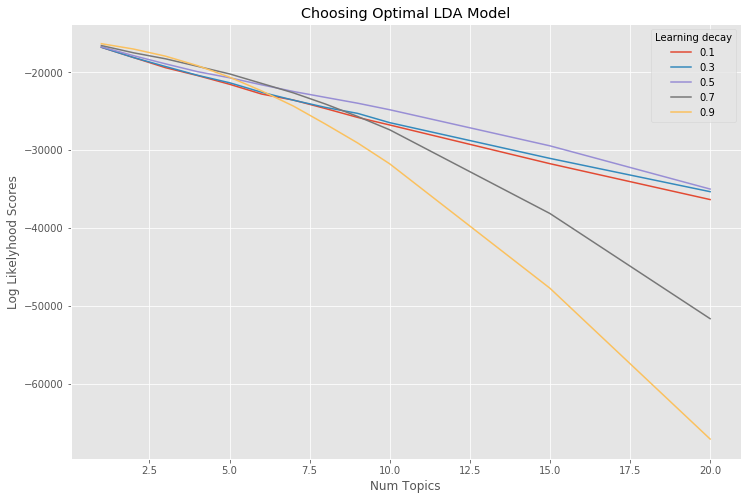

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_1, label='0.1')
plt.plot(n_topics, log_likelyhoods_3, label='0.3')
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [33]:
# 6) Write clean text to text file - one line per sentence
out_file = open("sample.txt", "w")
for sent in sentences1:
    out_file.write(sent.lower().replace("( ", "(").replace(" )", ")").replace("replaced-dns ", "").replace("replaced-dns", "").replace("replaced-url ", "").replace("replaced-url", "")+"\n")

out_file.close()

# sentences1 written to text file "sample.txt" for word2vec and LDA models

In [34]:
import tmtoolkit

In [35]:
from gensim.corpora.textcorpus import TextCorpus
corpus = TextCorpus("sample.txt")
dtm = tmtoolkit.bow.dtm.gensim_corpus_to_dtm(corpus=corpus)

In [36]:
dtm.getrow(1).todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [37]:
const_params = dict(n_iter = 100)
ks = list(range(10, 50, 5))
varying_params = [dict(n_topics = k, alpha = 1.0/k) for k in ks]
import numpy as np
dtm.dtype = np.int64

In [38]:
# eval_results = tm_lda.evaluate_topic_models(dtm,
#     varying_params,
#     const_params)

In [39]:
# results_by_n_topics = results_by_parameter(eval_results, 'n_topics')

# fig, ax = plt.subplots(figsize=(8, 6))
# plot_eval_results(fig, ax, results_by_n_topics)
# plt.tight_layout()
# plt.show()

In [40]:
vocab = {}
lda = LatentDirichletAllocation(n_topics = 10)
lda.fit(data_vectorized)

C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\Naveen\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1, n_topics=10,
             perp_tol=0.1, random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [41]:
dir(model)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_check_is_fitted',
 '_estimator_type',
 '_get_param_iterator',
 '_get_param_names',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'fit_params',
 'get_params',
 'grid_scores_',
 'iid',
 'inverse_transform',
 'multimetric_',
 'n_jobs',
 'n_splits_',
 'param_grid',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'refit',
 'return_train_scor

In [42]:
best_lda_model = model.best_estimator_
lda_output = best_lda_model.transform(data_vectorized)
from pandas import DataFrame
from numpy import round, argmax
# topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_topics)]
df_document_topic = DataFrame(round(lda_output, 2))
dominant_topic = argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']


In [43]:
df_topic_distribution.head()

,Topic Num,Num Documents
0,0,63


In [44]:
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.sklearn
panel = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\Naveen\Anaconda3\lib\site-packages\pyldavis-2.1.2-py3.6.egg\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2     -125.767075   -2.146713       1        1  26.862180
5      113.210136 -126.001892       2        1  16.071251
4      -59.979149   82.466866       3        1  16.064650
7        7.406869   16.312721       4        1  15.240268
9     -109.213303 -124.998825       5        1  12.497247
6      119.620369   -5.278120       6        1   5.594652
8       63.746899   90.327667       7        1   3.277890
1       -2.130025 -157.493820       8        1   2.860238
3      -47.569290  -55.714043       9        1   1.428170
0       42.419838  -67.427757      10        1   0.103454, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
985   Default  152.000000          image  152.000000  30.0000  30.0000
283   Default   40.000000            buy   40.000000  29.0000  29.0000
1684  Default   57.000000   replaced-url   57.000000  28.0000  28.0000
2262  Default   23.000000          zdnet   23.000000  27.0000  27.0000
603   Default   16.000000     downgraded   16.000000  26.0000  26.0000
1425  Default   17.000000       password   17.000000  25.0000  25.0000
1944  Default   13.000000         strong   13.000000  24.0000  24.0000
1854  Default   13.000000          slink   13.000000  23.0000  23.0000
459   Default   10.000000       coverage   10.000000  22.0000  22.0000
1013  Default   10.000000      initiated   10.000000  21.0000  21.0000
1009  Default   24.000000    information   24.000000  20.0000  20.0000
46    Default   12.000000        account   12.000000  19.0000  19.0000
1688  Default   14.000000        request   14.000000  18.0000  18.0000
1458  Default   15.000000        phillip   15.000000  17.0000  17.0000
2135  Default    8.000000       upgraded    8.000000  16.0000  16.0000
374   Default   51.000000            com   51.000000  15.0000  15.0000
654   Default    9.000000          email    9.000000  14.0000  14.0000
1026  Default    8.000000   intelligence    8.000000  13.0000  13.0000
966   Default    8.000000            ibs    8.000000  12.0000  12.0000
620   Default   17.000000         e-mail   17.000000  11.0000  11.0000
1457  Default    7.000000          phase    7.000000  10.0000  10.0000
1233  Default    9.000000        message    9.000000   9.0000   9.0000
1521  Default   11.000000          price   11.000000   8.0000   8.0000
2254  Default    8.000000           year    8.000000   7.0000   7.0000
1094  Default    7.000000           know    7.000000   6.0000   6.0000
970   Default    8.000000             id    8.000000   5.0000   5.0000
1135  Default    7.000000    lexis-nexis    7.000000   4.0000   4.0000
609   Default    3.000000           draw    3.000000   3.0000   3.0000
2018  Default    9.000000         thanks    9.000000   2.0000   2.0000
1294  Default   10.000000           need   10.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
1041  Topic10    0.003165            irs    1.883490   0.4850  -7.5627
1137  Topic10    0.003161        library    1.882962   0.4841  -7.5639
898   Topic10    0.003133           half    1.822193   0.5079  -7.5729
134   Topic10    0.003127       approach    1.809536   0.5130  -7.5748
1277  Topic10    0.003283            msn    2.379067   0.2882  -7.5259
1538  Topic10    0.003430       problems    3.107911   0.0648  -7.4821
1705  Topic10    0.003180    responsible    1.994552   0.4324  -7.5581
654   Topic10    0.004076          email    9.359673  -0.8652  -7.3096
1293  Topic10    0.003224      necessary    2.166497   0.3634  -7.5443
91    Topic10    0.003276         agreed    2.442240   0.2596  -7.5283
1883  Topic10    0.003285           spin    2.561597   0.2148  -7.5254
353   Topic10    0.004080          click   13.753840  -1.2493  -7.3088
106   Topic10    0.003744         amazon    7.817740  -0.7703  -7.

In [45]:
# Topic-Keyword Matrix
df_topic_keywords = DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()

# View
df_topic_keywords.head()

,-based,00,001,004,0079,00pm,012,013,030,08943a37-c26c-43ae-897a-13856df90795,...,yo,ys,yuletide,zd,zdnet,zdnn,zero,zip,zipper,zone
0,1.658693,5.205427,1.6243,1.597682,1.620529,2.179116,1.583165,1.618391,2.209308,1.59683,...,1.574209,1.605341,1.626662,4.608701,24.999374,1.582947,1.568962,2.849071,1.584155,1.597393


In [46]:
from numpy import array
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)

In [47]:
df_topic_keywords = DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,image,replaced-url,com,buy,information,zdnet,phillip,downgraded,e-mail,password,enron,request,strong,slink,account


In [48]:
# 3) Spell correct - currently correct only disjoint words
lengths = pos.apply(len)
inc_sentences = sentences1[lengths == 0]
# inc_labels = new_labels[lengths == 0]
pos = pos[lengths > 0]
# labels = new_labels[lengths > 0]
sentence_tokens = pos.apply(spell_correct_tokens)

# lengths -> used to remove sentences for which pos is not tagged
# sentences_tokens -> combine words in pos if: a) word and adjacent word are incorrectly spelled, b) combination of words is correctly spelled

In [49]:
# 4) Combine tokens to form bigrams and trigrams
# sentence_tokens = sentences.apply(tokenize_treetagger)
trigrams = apply_bigram_trigram_model(sentence_tokens)

# trigrams -> Series of lists: unigrams, bigram phrases (word1_word2) and trigram phrases (word1_word2_word3)

In [50]:
# 5) Form the sentence back from tokens
sentences1 = ["".join([" "+lemmatize_treetagger(run_treetagger(i.lower())) if not i.startswith("'") and i not in punctuation
                       else i for i in tokens]).strip() for tokens in trigrams]
# labels = labels.tolist() + inc_labels.tolist()

# Join the sentences back
# sentences1 -> list of strings

In [51]:
# 7) Run word2vec model and store word representations
model = run_word2vec_model("sample.txt")
model.wv.save_word2vec_format("big.w2v")

# Build word2vec model on "sample.txt" and save model to "big.w2v"

C:\Users\Naveen\Desktop\Coding\TextMining\visualizing.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = word2vec_model[word2vec_model.wv.vocab]


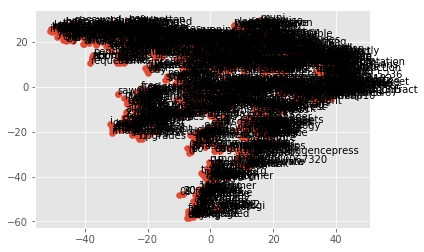

In [52]:
# 8) Visualizing the word2vec model
visualize_word2vec_model(model)

# Visualize word2vec model in 2d using t-SNE

In [53]:
# 9) Setting up the data for building logistic regression model
#df = zeros((len(sentences1), 100))
#for i, words in enumerate(trigrams):
#    for word in words:
#        try:
#            df[i] = df[i] + model[word]
#        except:
#            continue

#while(i<len(sentences1)):
#    i += 1
#
#df = DataFrame(df)
#df[label] = labels

# This is for building supervised learning model using sentence embeddings as predictors

In [54]:
# 10) Building and saving the logistic regression model with L1 penalty
#lr_model = build_logistic_regression(df, label)
#dump(lr_model, open("logistic_model.pkl", 'wb'))

# Build and dump the model

In [55]:
# 11) Topic modeling (Optional)
#lda_model = run_lda_topic_model(text_file = "sample_cleaned.txt")
# Sample topic modeling output - Topic 1
#lda_model.print_topic(1)

In [56]:
sim1 = get_semantic_similarity(model)

# Get m x m matrix of semantic (cosine) similarity between words in vocabulary

C:\Users\Naveen\Desktop\Coding\TextMining\util.py:642: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  mat = word2vec_model[word2vec_model.wv.vocab]


In [57]:
vocab = list(model.wv.vocab)

# Get all m words in vocabulary

In [58]:
# ratio = get_character_similarity(vocab, 'ratio')

# Compute m x m character-based similarity metric between words in vocabulary

In [59]:
# partial_ratio = get_character_similarity(vocab, "partial_ratio")

In [60]:
# token_sort_ratio = get_character_similarity(vocab, "token_sort_ratio")

In [61]:
# token_set_ratio = get_character_similarity(vocab, "token_set_ratio")

In [62]:
# sim1 = sim1[ratio.columns]
# sim1 = sim1.loc[ratio.columns]

# sim1 is m x m matrix

In [63]:
# semantic_weight = 0.5
# ratio_weight = 0.4
# partial_ratio_weight = 0.4
# token_sort_ratio_weight = 0.1
# sim = semantic_weight*sim1 + (ratio_weight*ratio + partial_ratio_weight*partial_ratio + token_sort_ratio_weight*token_sort_ratio + (1-ratio_weight-partial_ratio_weight-token_sort_ratio_weight)*token_set_ratio)*(1-semantic_weight)
# dist = 1 - sim

# Currently heuristic weights are assigned for different similarities
# dist is m x m matrix

In [64]:
# aff = run_aff_prop_with_distances(dist)

# Run affinity propagation model on computed composite distance matrix and store in aff

In [65]:
# visualize_word2vec_model(model, aff.labels_)

# Visualize word2vec model with labels as per affinity propagation clusters

In [66]:
# columns = sim.columns
# condition = Series(sim.columns).apply(is_spelled_correctly)
# sim = sim.loc[columns[~condition]]
# sim = sim[columns[condition]]

# Identify mis-spelled words and find nearest words; words with '_' are also considered correct (this needs some thought)

In [67]:
# sim.apply(lambda x: x.sort_values().index[0], axis = 1)

In [68]:
df = DataFrame(model.wv[model.wv.vocab])
df.columns = ['c' + str(i) for i in range(df.shape[1])]
km = run_kmeans(model.wv[model.wv.vocab])

# Run kmeans model and store in km object

C:\Users\Naveen\Desktop\Coding\TextMining\visualizing.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = word2vec_model[word2vec_model.wv.vocab]


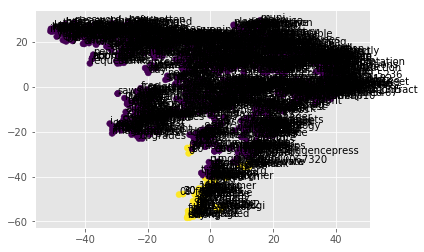

In [69]:
visualize_word2vec_model(model, km.cluster)

# Visualize word2vec with kmeans cluster labels

In [70]:
lda_model, corpus, dictionary = run_lda_topic_model(text_file = "sample.txt")

# Run gensim LDA model on "sample.txt" and return model (lda_model), corpus (corpus) and dictionary (dictionary)

C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(ge

C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(ge

C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(ge

C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(ge

C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Naveen\Anaconda3\lib\site-packages\gensim-3.6.0-py3.6-win-amd64.egg\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(ge

In [71]:
lda_model.print_topics(-1)

# Prints all topics

[(0,
  '0.039*"distribution" + 0.038*"psa" + 0.037*"stock" + 0.031*"shares" + 0.026*"account" + 0.023*"section" + 0.023*"deferral" + 0.023*"plan" + 0.023*"balance" + 0.019*"6"'),
 (1,
  '0.047*"35" + 0.007*"request" + 0.005*"10" + 0.004*".com" + 0.004*"resource" + 0.004*"id" + 0.004*"approval" + 0.004*"000000000067320" + 0.003*"type" + 0.003*"auth"'),
 (2,
  '0.004*"information" + 0.003*"password" + 0.003*"6" + 0.003*"ssn" + 0.003*"please" + 0.003*"last" + 0.002*"account" + 0.002*"3" + 0.002*"ibs" + 0.002*"primary"'),
 (3,
  '0.000*"economic" + 0.000*"electricity" + 0.000*"division" + 0.000*"dj" + 0.000*"djia" + 0.000*"dmark" + 0.000*"dollar" + 0.000*"domestic" + 0.000*"drillin" + 0.000*"demand"'),
 (4,
  '0.037*"request" + 0.032*"pursing" + 0.029*"days" + 0.012*".com" + 0.011*"review" + 0.010*"replaced-url" + 0.007*"http://cgi" + 0.007*".zdnet" + 0.006*"enron" + 0.005*"slink"'),
 (5,
  '0.000*"economic" + 0.000*"electricity" + 0.000*"division" + 0.000*"dj" + 0.000*"djia" + 0.000*"dmar

In [72]:
from util import get_word_lda_topics
Series(list(lda_model.id2word.values())).apply(lambda x: get_word_lda_topics(lda_model, x))

# Supposed to get list of all topics for each word in vocab -> not working for some reason (returns None)

0          (curve, [(16, 0.018038992), (37, 0.01196886)])
1                          (heather, [(16, 0.018038992)])
2       (know, [(16, 0.018038992), (90, 0.01864229), (...
3       (let, [(16, 0.018153133), (90, 0.01864229), (9...
4       (need, [(11, 0.010920561), (16, 0.018038992), ...
5       (please, [(11, 0.011157273), (15, 0.03425374),...
6          (shift, [(16, 0.018038992), (37, 0.01196886)])
7          (still, [(16, 0.01812632), (28, 0.010723401)])
8       (thanks, [(16, 0.018038992), (19, 0.021398382)...
9                                       (.anchordesk, [])
10      (.com, [(15, 0.032899916), (30, 0.010638606), ...
11                           (.html, [(15, 0.018879486)])
12         (.zdnet, [(87, 0.02172496), (92, 0.03790373)])
13                                 (0, [(13, 0.0473794)])
14      (00, [(30, 0.028380407), (121, 0.012846059), (...
15                                           (130228, [])
16                                            (14179, [])
17            

In [73]:
from gensim.models.ldamodel import LdaModel


In [74]:
from visualizing import visualize_lda_topics
visualize_lda_topics(lda_model, corpus, dictionary)

# Visualize LDA model using MDS

C:\Users\Naveen\Anaconda3\lib\site-packages\pyldavis-2.1.2-py3.6.egg\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


TypeError: Object of type 'complex' is not JSON serializable

PreparedData(topic_coordinates=                                x                             y  topics  \
topic                                                                     
120     (0.009094596784640968+0j)      (0.16341874294440661+0j)       1   
13      (-0.08674229707836612+0j)      (0.20768394548305424+0j)       2   
92      (-0.20065466637878993+0j)       (0.1240211500989384+0j)       3   
140     (-0.21284395573220716+0j)     (-0.18807485569570714+0j)       4   
111      (-0.2512257219466787+0j)      (0.29838132942351464+0j)       5   
15       (-0.3436531395291721+0j)     (-0.06863132741829943+0j)       6   
112     (-0.21575127636433705+0j)       (0.2827851838248951+0j)       7   
30      (-0.22410676559719556+0j)     (0.018292520782509335+0j)       8   
41       (-0.2792965958268683+0j)     (0.022701140079625315+0j)       9   
53       (-0.2078975687316159+0j)     (-0.19019393744270216+0j)      10   
149      (-0.2530841850277412+0j)     (0.022130125468845862+0j)      

In [75]:
from sentiment_analysis import tag_sentiment_nltk
from util import get_sentiment_with_highest_score

In [76]:
from sentiment_analysis import tag_sentiment_nltk
Series(sentences1).apply(tag_sentiment_nltk).apply(get_sentiment_with_highest_score)

# Tag sentiments and return sentiment with highest probability

C:\Users\Naveen\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


0     neu
1     neu
2     neu
3     neu
4     neu
5     neu
6     neu
7     neu
8     neu
9     neu
10    neu
11    neu
12    neu
13    neu
14    neu
15    neu
16    neu
17    neu
18    neu
19    neu
20    neu
21    neu
22    neu
23    neu
24    neu
25    neu
26    neu
27    neu
28    neu
29    neu
     ... 
33    neu
34    neu
35    neu
36    neu
37    neu
38    neu
39    neu
40    neu
41    neu
42    neu
43    neu
44    neu
45    neu
46    neu
47    neu
48    neu
49    neu
50    neu
51    neu
52    neu
53    neu
54    neu
55    neu
56    neu
57    neu
58    neu
59    neu
60    neu
61    neu
62    neu
Length: 63, dtype: object

In [77]:
from sentiment_analysis import tag_sentiment_stanfordcorenlp
tag_sentiment_stanfordcorenlp(sentences1[0])

['Negative', 'Positive', 'Neutral']

In [78]:
Series(sentences1).apply(tag_sentiment_stanfordcorenlp)

0                         [Negative, Positive, Neutral]
1     [Positive, Neutral, Positive, Neutral, Neutral...
2     [Negative, Neutral, Positive, Negative, Negati...
3     [Negative, Neutral, Neutral, Neutral, Negative...
4     [Positive, Neutral, Neutral, Negative, Positiv...
5     [Negative, Negative, Neutral, Negative, Neutra...
6     [Positive, Neutral, Positive, Negative, Neutra...
7     [Negative, Neutral, Positive, Negative, Negati...
8     [Negative, Neutral, Positive, Negative, Negati...
9     [Negative, Negative, Neutral, Negative, Neutra...
10                         [Neutral, Positive, Neutral]
11    [Negative, Neutral, Neutral, Negative, Negativ...
12      [Negative, Negative, Neutral, Neutral, Neutral]
13    [Neutral, Positive, Negative, Neutral, Neutral...
14    [Neutral, Negative, Positive, Positive, Neutra...
15    [Positive, Positive, Neutral, Neutral, Neutral...
16              [Positive, Positive, Positive, Neutral]
17    [Neutral, Neutral, Neutral, Positive, Posi

In [79]:
sentences2 = sentences.apply(lambda x: " ".join(x))
sentences2.apply(tag_sentiment_stanfordcorenlp)

0                         [Positive, Positive, Neutral]
5     [Neutral, Neutral, Negative, Neutral, Neutral,...
6     [Negative, Negative, Positive, Positive, Negat...
7     [Positive, Neutral, Neutral, Neutral, Negative...
8     [Positive, Negative, Neutral, Negative, Positi...
9     [Negative, Positive, Neutral, Neutral, Negativ...
10    [Neutral, Neutral, Positive, Negative, Neutral...
12    [Negative, Negative, Positive, Positive, Negat...
13    [Negative, Negative, Positive, Positive, Negat...
14    [Negative, Positive, Neutral, Neutral, Negativ...
15                         [Neutral, Positive, Neutral]
16    [Negative, Neutral, Neutral, Positive, Neutral...
17       [Negative, Neutral, Neutral, Neutral, Neutral]
19    [Negative, Positive, Negative, Neutral, Neutra...
21    [Neutral, Neutral, Positive, Positive, Neutral...
22    [Neutral, Positive, Neutral, Neutral, Negative...
23               [Neutral, Positive, Positive, Neutral]
24    [Neutral, Neutral, Neutral, Neutral, Posit